#  Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, I train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are to:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [4]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

#### Q0. Loading the data (given)

In [5]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


#### Q1. How does load vary over the year in Texas?

Text(0,0.5,'Net demand of Texas (in MW)')

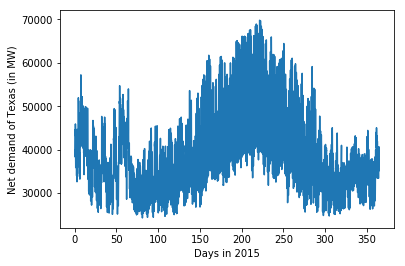

In [7]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (5 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.**


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


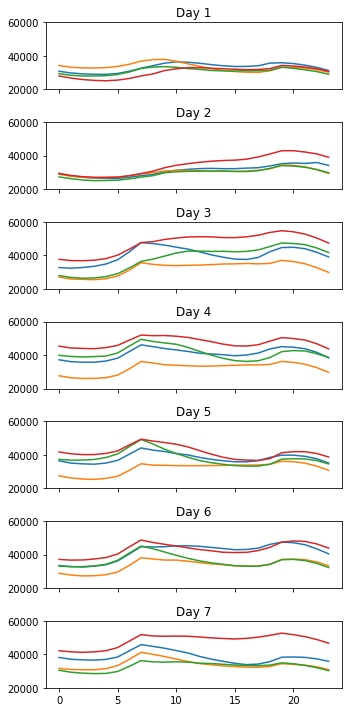

In [8]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? Do your observations agree with Q1? 

**Your answer (comments here, code below).**

 There is almost no difference in consumption between weekdays and weekends and the overall consumption has increased for both. This makes sense because it agrees with the year long cycle and we see a net increase in consumption in the summer months due to ACs. I think that there is a smaller difference between the weekends and the weekdays in the summer because cooling in Texas is a necessity while heating might be a luxury (due to warm winters and extremely hot summers). So the demand for power during the summer is relatively inelastic compared to the wintertime.

Additionally, we see a sharp increase in consumption during the day when the temperature is at its greatest. However, the peak is not at hour 12 but at hour 17. This is probably because people come home from work/school and the overall consumption increases due to the population spreading out over many homes as opposed to being concentrated a few schools/offices.

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


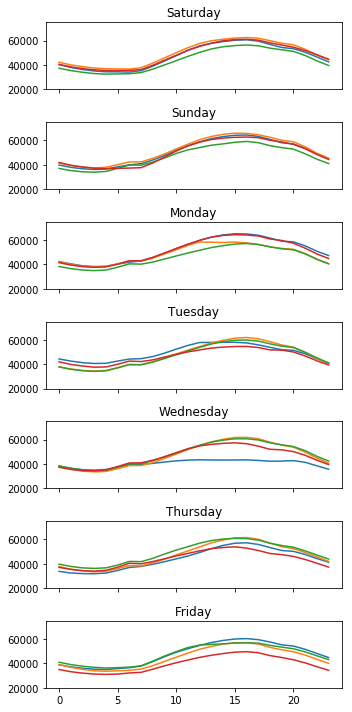

In [9]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 227
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

# :) 
EasierToRead = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
#     axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))
    axs[dayInFirstWeek].set_title(EasierToRead[dayInFirstWeek])

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [10]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [11]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

Recall that TensorFlow defines a computation graph where the weights and biases associated with the NN are variables. The goal is to optimize the weights and biases of the NN to minimize prediction error using data. 


To define the computation graph, create the inputs and outputs as 'placeholders'.
The algorithm only expects them to be specified at the time of computation. The
first element of the shape attribute for both inputs and outputs are 'None'. This
means that they are left unspecified, and will be provided at runtime. It will help
in batch training for prediction, where the size of the batch will determine
this value. Batch training is useful because training the NN with one data point at a
time can be time consuming.

In this lab, we begin with a 'relu' activation. We additionally implement 'dropouts' that basically
prevents certain paramters from updating in each round. This is known to prevent overfitting. The number'0.995' in the description below updates 99.5% of all weights, leaving out 0.5%.

Design the optimizer and the loss. For reporting the accuracy of prediction, we choose in this lab the idea of mean absolute error (MAE). For a data set, if the true values are scalars $y_1, \ldots, y_m$ and the predictions are $\hat{y}_1, \ldots, \hat{y}_m$, then its MAE is given by
$$ MAE = \frac{1}{m}\sum|y_i - \hat{y}_i|.$$
If $y$ and $\hat{y}$ are multidimensional, it computes the average across each coordinate of $y$ and $\hat{y}$.

**Question (5 points). Insert a line of code for the output of layer 1 below (use the relu function)** 

In [12]:
# Hidden layer size
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the weights, biases of the first layer.
W1 = tf.Variable(tf.random.truncated_normal(shape = [nDimX, nHidden]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden]))

# Define the weights, biases of the second layer.
W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))


# Construct the neural network
@tf.function
def neuralNetworkModel(X):
    global W1, b1, W2, b2
    
    Z1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    Z1 = tf.nn.dropout(Z1, 0.005)
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
    Z2 = tf.nn.dropout(Z2, 0.005)
    
    return Z2
    

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).
MSE = tf.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = tf.optimizers.Adagrad(learning_rate)

# Define the metric (MAE - mean absolute error)
MAE = tf.metrics.mean_absolute_error
trainable_variables = [W1, b1, W2, b2]



### Train the neural network.

Create the training module for the NN. Feed the training data in batches of size 'batchSize'
and ask Tensorflow to run the function 'optimizer'. The number of batches, denoted by 'nBatches'
is then given by the size of your training dataset divided by 'batchSize. Usually, going through
the training data once does not train your NN. You train over the same data multiple
times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn
a material by reading through it once!

In [13]:
import time
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define the training scheme
def train(model, trainX, trainY):
    for epoch in range(nEpochs):
        lossEpoch = 0
        
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            
            # Define the batch to train on.
            
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]
            
            # Fit the batch data and compute the gradients
            with tf.GradientTape() as tape:
                prediction = model(batchX)
                loss = MSE(y_true=batchY, y_pred=prediction)

                # Print update
                lossEpoch = lossEpoch + loss.numpy()

                # Optimize the weights
                gradients = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(gradients, trainable_variables))
         
        current = time.time()
        
        if(epoch == 10 or epoch % 99 == 0) :
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            print(time.time() - current)
            current = time.time()
        

print("Started the training module.")

train(neuralNetworkModel,trainX,trainY)

print("Training process completed.")

Started the training module.
Epoch: 1, Loss: = 8246108032.0
8.416175842285156e-05
Epoch: 11, Loss: = 8188937344.0
8.559226989746094e-05
Epoch: 100, Loss: = 7704112512.0
7.43865966796875e-05
Epoch: 199, Loss: = 7158389120.0
7.081031799316406e-05
Epoch: 298, Loss: = 6642339712.0
8.702278137207031e-05
Epoch: 397, Loss: = 6166753920.0
8.296966552734375e-05
Epoch: 496, Loss: = 5725748672.0
7.843971252441406e-05
Epoch: 595, Loss: = 5313950400.0
8.58306884765625e-05
Epoch: 694, Loss: = 4939857792.0
8.463859558105469e-05
Epoch: 793, Loss: = 4604865984.0
8.726119995117188e-05
Epoch: 892, Loss: = 4296573184.0
8.630752563476562e-05
Epoch: 991, Loss: = 4009934784.0
8.58306884765625e-05
Epoch: 1090, Loss: = 3766873408.0
8.988380432128906e-05
Epoch: 1189, Loss: = 3526664128.0
0.00011014938354492188
Epoch: 1288, Loss: = 3343782784.0
9.369850158691406e-05
Epoch: 1387, Loss: = 3140271776.0
8.797645568847656e-05
Epoch: 1486, Loss: = 2984538432.0
0.00011420249938964844
Epoch: 1585, Loss: = 2828142016.0
0

### Test the accuracy of prediction via NN.

Here, you report the mean absolute error of your predictions over the 'testX' dataset. Finally, plot the actual demand profile versus the predicted demand profile for a few days from the test data.

Mean absolute error of forecast =  15383.686
Max value of testY is 69716


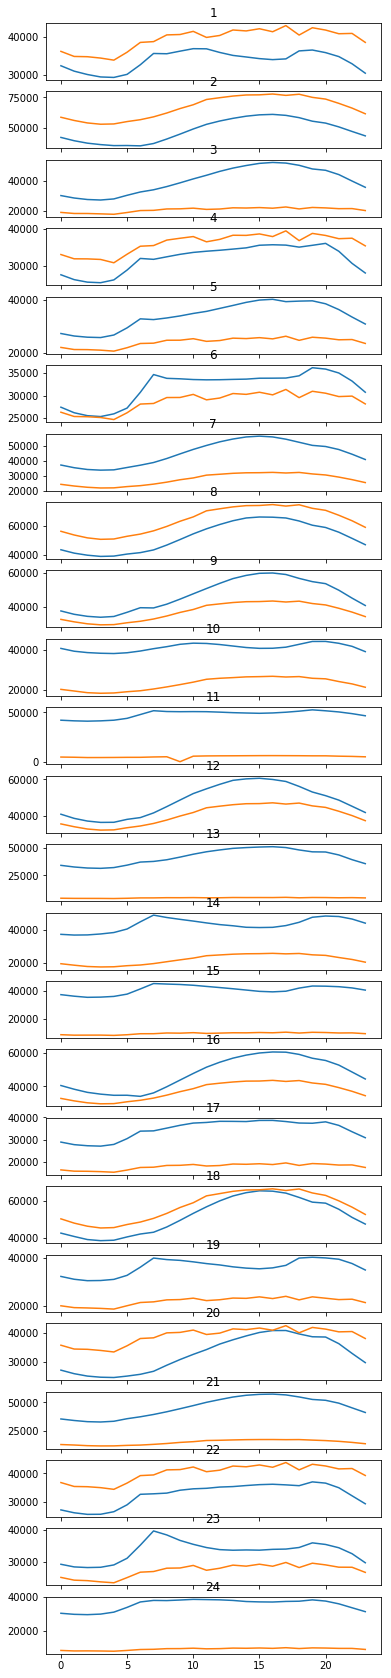

In [14]:
predictedY =  neuralNetworkModel(testX)# insert code
maeOfPrediction = np.mean(MAE(testY, predictedY))

print("Mean absolute error of forecast = ", maeOfPrediction)

testY = np.array(testY)
textMax = np.amax(testY)
print("Max value of testY is", textMax)

hours_in_a_day = 24
fig, axs = plt.subplots(24, 1, sharex=True, figsize=(6,30))
axs = axs.ravel()

for hour in range(hours_in_a_day):
    axs[hour].plot(testY[hour])
    axs[hour].plot(predictedY[hour])
    axs[hour].set_title(hour+1)

### Let us visualize the results.


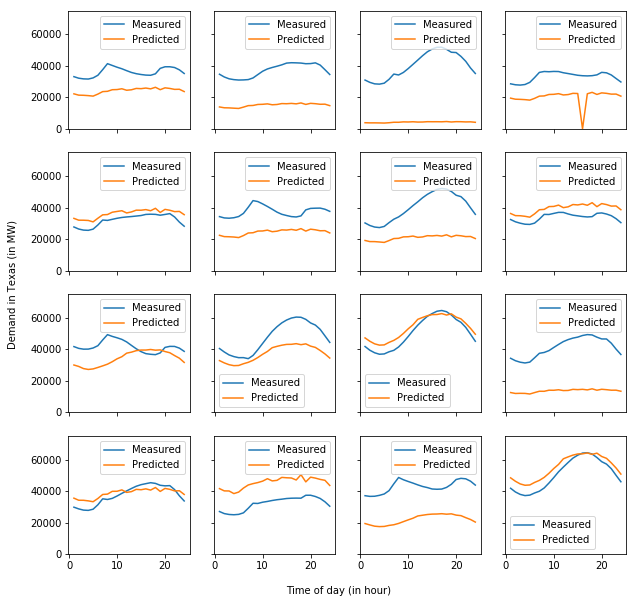

In [15]:
# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()

for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')

    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

### The effect of wind energy (bonus).

In [16]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
5,1/1/15 5:00,1-Jan,38877,745,12730,1.9,5.9,94.0,14.5
6,1/1/15 6:00,1-Jan,39837,788,12730,2.0,6.2,43.0,5.8
7,1/1/15 7:00,1-Jan,40520,758,12730,1.9,6.0,-30.0,-3.8
8,1/1/15 8:00,1-Jan,41008,668,12730,1.6,5.2,-90.0,-11.8
9,1/1/15 9:00,1-Jan,42052,496,12730,1.2,3.9,-172.0,-25.8


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. Bonus points Awarded for high accuracy

**Your answer (comments here, code below).**

Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


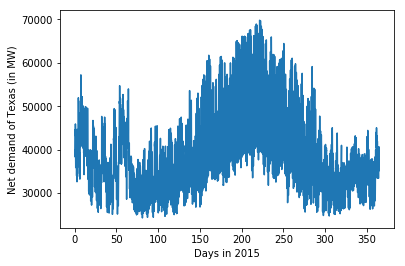

In [18]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]

X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

In [20]:
import time

nHidden1 = 150
nHidden2 = 150
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 10000

nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

W1 = tf.Variable(tf.random.truncated_normal(shape = [nDimX, nHidden]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden1]))


W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden1, nHidden2]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden2]))


W3 = tf.Variable(tf.random.truncated_normal(shape=[nHidden2, nDimY]))
b3 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))

@tf.function
def My2ndNeuralNetworkModel(X):
    global W1, b1, W2, b2, W3, b3
    Z1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    Z1 = tf.nn.dropout(Z1, 0.005)
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
    Z2 = tf.nn.dropout(Z2, 0.005)
    Z3 = tf.nn.relu(tf.matmul(Z2, W3) + b3)
    Z3 = tf.nn.dropout(Z3, 0.005)
    return Z3

MSE = tf.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = tf.optimizers.Adagrad(learning_rate)
MAE = tf.metrics.mean_absolute_error
trainable_variables = [W1, b1, W2, b2, W3, b3]

def My2ndTrain(model, trainX, trainY):
    for epoch in range(nEpochs):
        lossEpoch = 0
        for n in range(nBatches):
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]
            with tf.GradientTape() as tape:
                prediction = model(batchX)
                loss = MSE(y_true=batchY, y_pred=prediction)
                lossEpoch = lossEpoch + loss.numpy()
                gradients = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(gradients, trainable_variables))
        current = time.time()
        if(epoch== 10 or epoch % 200 == 0 or epoch == 9999):
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            print(time.time() - current)
            current = time.time()


print("Started the training module.")
My2ndTrain(My2ndNeuralNetworkModel,trainX,trainY)
print("Training process completed.")

Started the training module.
Epoch: 1, Loss: = 8076888832.0
8.368492126464844e-05
Epoch: 11, Loss: = 6455706240.0
8.177757263183594e-05
Epoch: 201, Loss: = 1639488576.0
8.916854858398438e-05
Epoch: 401, Loss: = 1108146544.0
8.344650268554688e-05
Epoch: 601, Loss: = 840967936.0
0.00010442733764648438
Epoch: 801, Loss: = 783955552.0
8.726119995117188e-05
Epoch: 1001, Loss: = 754758272.0
0.0005962848663330078
Epoch: 1201, Loss: = 734110416.0
0.00011444091796875
Epoch: 1401, Loss: = 717814936.0
0.0001327991485595703
Epoch: 1601, Loss: = 705666952.0
8.845329284667969e-05
Epoch: 1801, Loss: = 697151272.0
8.463859558105469e-05
Epoch: 2001, Loss: = 678203712.0
9.083747863769531e-05
Epoch: 2201, Loss: = 664136576.0
8.749961853027344e-05
Epoch: 2401, Loss: = 655745280.0
0.00010323524475097656
Epoch: 2601, Loss: = 637130984.0
0.00010943412780761719
Epoch: 2801, Loss: = 627664264.0
8.368492126464844e-05
Epoch: 3001, Loss: = 622238904.0
8.821487426757812e-05
Epoch: 3201, Loss: = 617875720.0
0.00016

Mean absolute error of forecast =  4625.7373
Max value of testY is 68426


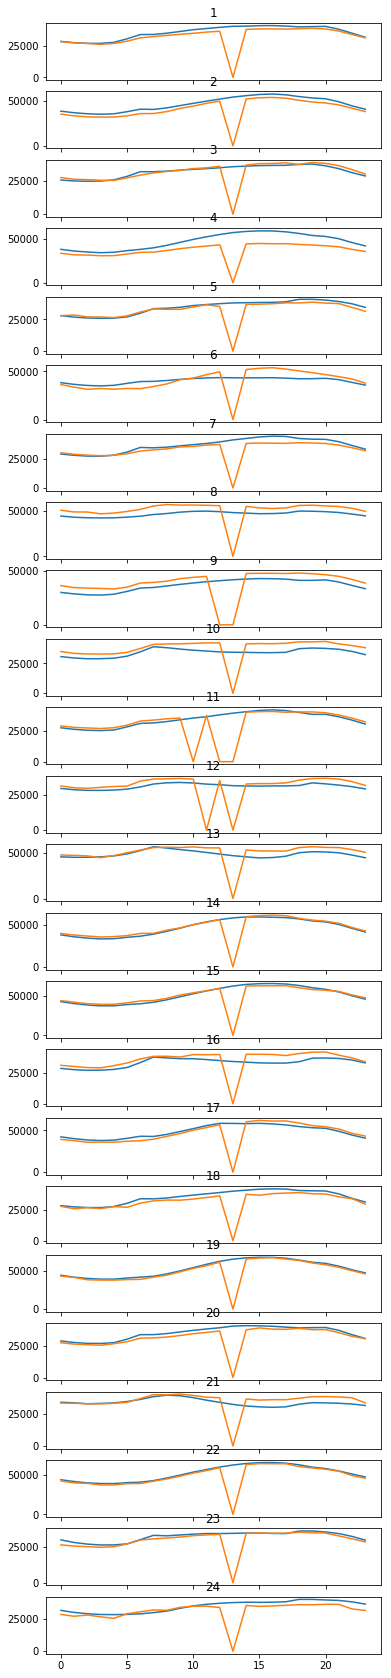

In [21]:
predictedY =  My2ndNeuralNetworkModel(testX)
maeOfPrediction = np.mean(MAE(testY, predictedY))

print("Mean absolute error of forecast = ", maeOfPrediction)

testY = np.array(testY)
textMax = np.amax(testY)
print("Max value of testY is", textMax)

hours_in_a_day = 24
fig, axs = plt.subplots(24, 1, sharex=True, figsize=(6,30))
axs = axs.ravel()

for hour in range(hours_in_a_day):
    axs[hour].plot(testY[hour])
    axs[hour].plot(predictedY[hour])
    axs[hour].set_title(hour+1)

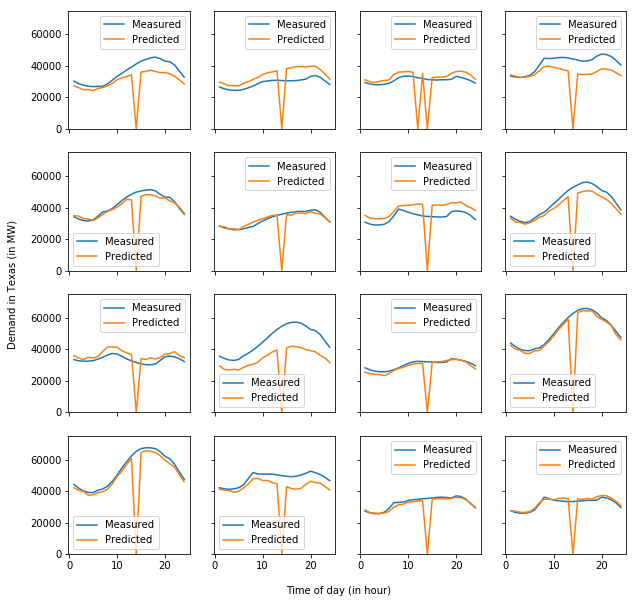

In [22]:
# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()

for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')

    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()